In [1]:
import netCDF4 as nc4
import keras
import xarray,numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import  Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils
from tensorflow.keras import layers

# Read data

In [2]:
file_path =['C:/Users/myxll/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_01.nc']
file_path.append('C:/Users/myxll/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_02.nc')
file_path.append('C:/Users/myxll/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_03.nc')
file_path.append('C:/Users/myxll/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_04.nc')
file_path.append('C:/Users/myxll/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_05.nc')
file_path.append('C:/Users/myxll/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_06.nc')
ds = nc4.MFDataset(file_path)
eta_t = ds.variables['eta_t'][:]
eta_t_numpy = np.array(eta_t)
eta_t_numpy = np.nan_to_num(eta_t_numpy)
eta_t_numpy.shape

(182, 1500, 3600)

# fixed missing values with 0

In [8]:
def fix_missing_value(input_data):
    for i in range(0,len(input_data)):
        arr = input_data[i]
        arr[arr == -32768] = 0

# Normalize the input

In [9]:
def normalize_matrix(matrix):
    norm = np.linalg.norm(matrix)
    matrix = matrix/norm  # normalized matrix
    return matrix


# Split array into 128*128

In [10]:
import math
lat = 128
long = 128
def split_array(input_data):
    pad_rows = math.ceil(3600/lat)*lat - 3600
    pad_cols = math.ceil(1500/long)*long - 1500
#     print(pad_rows)
#     print(pad_cols)
    
    input_data=np.pad(input_data,((0,pad_cols),(0,pad_rows)), 'constant',constant_values=(0,0)) # padding with zeros
    
    l = np.array_split(input_data,len(input_data)/lat,axis=0)
    input_data_split = []
    for i in range(len(l)):
        dd = np.array_split(l[i],29,axis=1)
        input_data_split += dd
    input_data_split = np.array(input_data_split)
    return input_data_split

In [11]:
input_data_split = []
lat = 128
long = 128
for i in range(len(eta_t_numpy)):
    input_data = eta_t_numpy[i,:,:]
    fix_missing_value(input_data)

    normalize_matrix(input_data)

    input_data_split.append(split_array(input_data)[100])

In [12]:
input_data_split= np.array(input_data_split)

In [13]:
np.save('128x128_6months',input_data_split)

# split train set & validation set

In [14]:
train_set, test_set = train_test_split(input_data_split, test_size=0.33)
train_set.shape

(121, 128, 128)

# Autoencoder

In [15]:
input_img = keras.Input(shape=(128, 128,1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu',strides=(1,1))(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same',strides=(2,2))(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((4, 4))(x)
decoded = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 4)         292       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 4)           0     

In [16]:
history = autoencoder.fit(train_set, train_set,
                epochs=100, validation_data=(test_set, test_set))

Epoch 1/100
4/4 [==============================] - 4s 899ms/step - loss: 0.0359 - val_loss: 0.0349
Epoch 2/100
4/4 [==============================] - 1s 243ms/step - loss: 0.0349 - val_loss: 0.0340
Epoch 3/100
4/4 [==============================] - 1s 247ms/step - loss: 0.0337 - val_loss: 0.0328
Epoch 4/100
4/4 [==============================] - 1s 232ms/step - loss: 0.0326 - val_loss: 0.0308
Epoch 5/100
4/4 [==============================] - 1s 239ms/step - loss: 0.0301 - val_loss: 0.0275
Epoch 6/100
4/4 [==============================] - 1s 253ms/step - loss: 0.0267 - val_loss: 0.0240
Epoch 7/100
4/4 [==============================] - 1s 279ms/step - loss: 0.0236 - val_loss: 0.0235
Epoch 8/100
4/4 [==============================] - 1s 265ms/step - loss: 0.0229 - val_loss: 0.0215
Epoch 9/100
4/4 [==============================] - 1s 271ms/step - loss: 0.0209 - val_loss: 0.0200
Epoch 10/100
4/4 [==============================] - 1s 273ms/step - loss: 0.0193 - val_loss: 0.0175
Epoch 11/

4/4 [==============================] - 1s 295ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 84/100
4/4 [==============================] - 1s 274ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 85/100
4/4 [==============================] - 1s 271ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 86/100
4/4 [==============================] - 1s 273ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 87/100
4/4 [==============================] - 1s 273ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 88/100
4/4 [==============================] - 1s 275ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 89/100
4/4 [==============================] - 1s 273ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 90/100
4/4 [==============================] - 1s 272ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 91/100
4/4 [==============================] - 1s 273ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 92/100
4/4 [==============================] - 1s 272ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 93/100


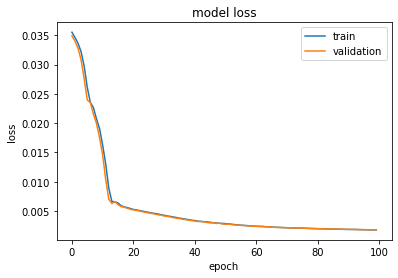

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()